# Scratch notes - Patchscopes streamlit tutorial

Five tasks, forming rough tutorial structure:  
1. Decoding next-token predictions     
    a. Logit Lens - original  
    b. Logit Lens - via Patchscope  
    c. Tuned Lens - original  
    d. Tuned Lens - via Patchscope  
    e. Future Lens - original  
    f. Future Lens - via Patchscope  
    g. Token identity Patchscope  
3. Attribute extraction  
    a. LRE Attribute Lens - original  
    b. LRE Attribute Lens - via Patchscope  
    c. Probing  
    d. Feature extraction Patchscope   
5. Entity resolution  
    a. Causal Tracing - original  
    b. Causal Tracing - Patchscope  
    c. Attention Knockout - original  
    d. Attention Knockout - Patchscope  
    e. Entity Description Patchscope  
    f. X-model Entity Description Patchscope   
7. Cross-model patching  
    a. N/A?   
9. Multi-hop reasoning  
    a. N/A?  

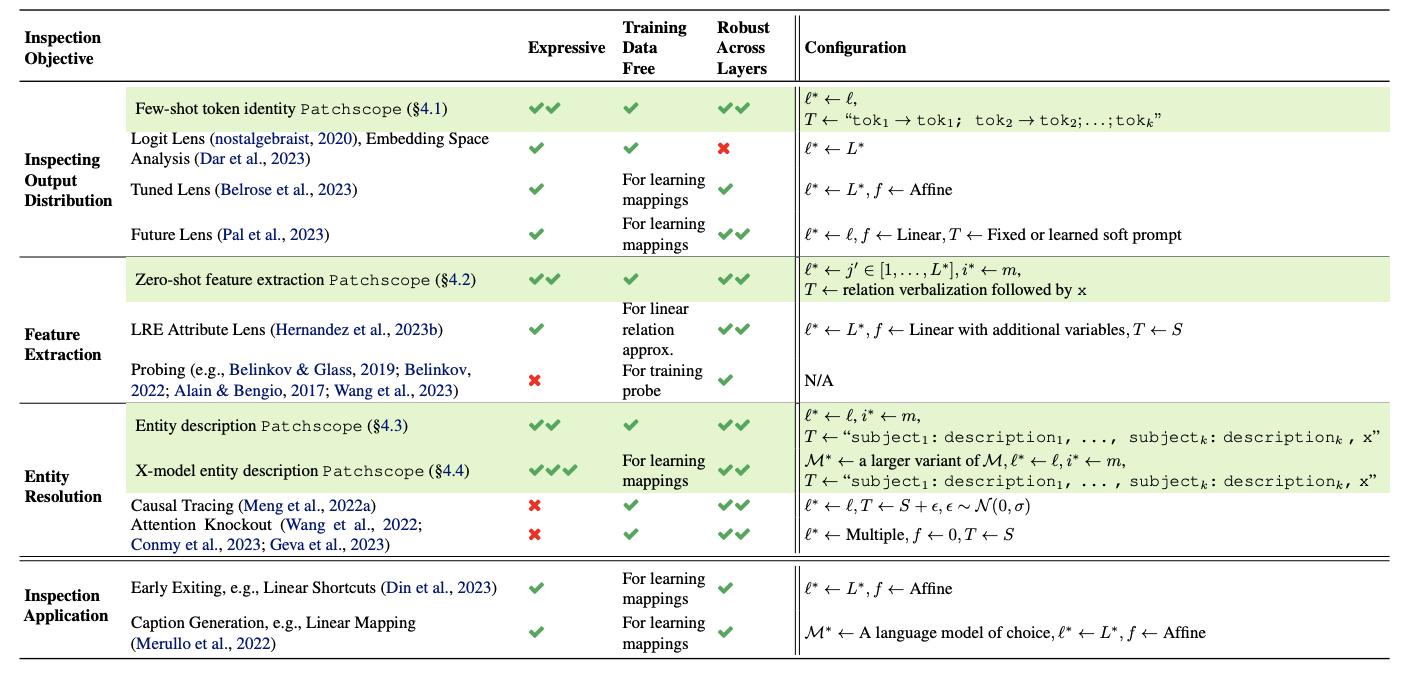


# Section 1a - Decoding next-token predictions via Logit Lens

We'll also need the models used in this experiment (Figure 2):
1. Vicuna-13B
2. LLAMA2-13B
3. Pythia-12B
4. GPT-J-6B

These should all be available via nnsight --> HuggingFace

To do:
- Run Logit Lens on these

Patchscope experiment notes:
- 12k random samples from the Pile (10k for training affine mappings in lenses, 2k for evaluation)
- "In our pre-processing strategy, we introduce randomness in the patching positions by trimming the input sequence length of each example."

Differences between Logit Lens and Patchscopes:
- Logit Lens, at each layer, just returns the residual stream at the end of every layer, multiplied by the unembedding matrix. We then get vectors of probabilities in vocab space, each of which represents the model's predictions for the next token, for every token in the input.
- The Logit Lens examines, for every layer and input token pair, the predicted token.
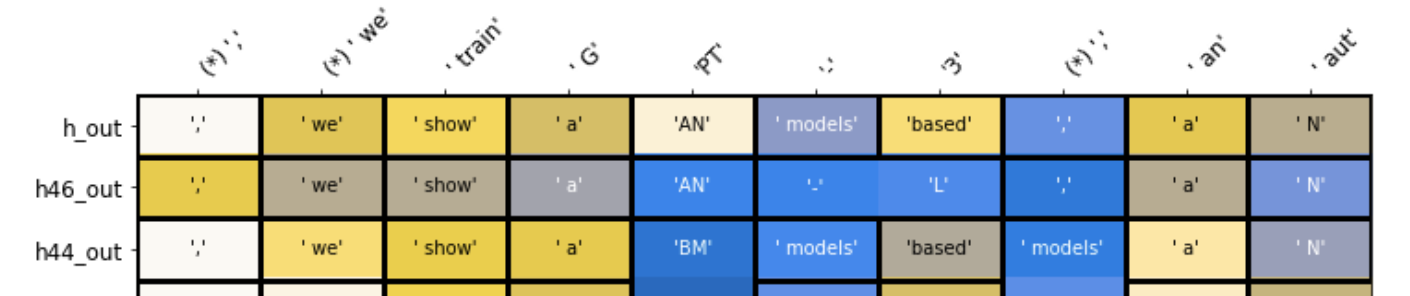
- In this way, we can see how the predicted tokens change, as we move forward through the model.
- Patchscopes says, they multiply "the final-layer last-position hidden representation h^L by the unembedding matrix WU ∈ |V |×d", to get some output distribution p^L. 
- But I think crucially, they want to estimate p^L from intermediate representations in the model, and not the output tokens. i.e. they want to see how quickly they can recover the output predictions for the last position, which will be of shape (vocab size).
- So for logit lens, we should do the same.
- The below snippets verify this for me:
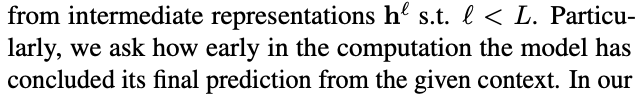
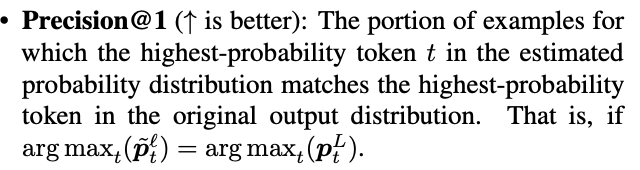
- Note, that taking the residual stream, at the end of a layer, and at a certain position, then unembedding it, doesn't give the logits yet. Need to softmax:
- 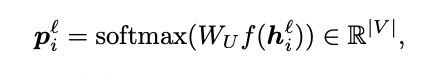
- Another key difference between the Logit Lens and ~~Patchscopes Logit Lens (also called the Token Identity in 4.1)~~ (that's not right, patchscopes logit lens and patchscopes token identity are two different things. Should read "between the Logit Lens and Patchscopes Token Identity), is the use of a target prompt T which is different to the source prompt (I assume from the Pile). The prompt is of the below format:
- 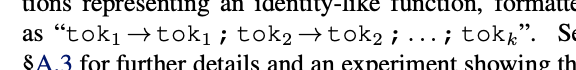
- I don't really know why this has been used, instead of just keeping the source prompt.
- I also don't understand the line,"In our pre-processing strategy, we introduce randomness in the patching positions by trimming the input sequence length of each example.". My current suspicion is this: https://aisafetycamp.slack.com/archives/C06BLFTEZNZ/p1709123993502799
- So, generate a dataset from the Pile, where each entry varies in number of tokens?
- But I do see how we're going to want to test:
- The original logit lens implementation
- The logit lens re-created via Patchscopes
- The Patchscopes solution to the problem in question. In this case, decoding next-token prediction (note, NOT next-token prediction). This third option is highlighted in green for each task above.


## Load data from the Pile

In [ ]:
# See issue mentioned below: https://github.com/huggingface/datasets/issues/5388
! poetry add zstandard
! poetry add datasets

In [ ]:
from datasets import load_dataset

lds = load_dataset(
    "json",
    data_files="val.jsonl.zst",#
    split="train",
    streaming=True,
)
next(iter(lds))

Wow, that was harder than it should have been. Lots of zst decompressing errors can arise. Steps taken:
1. Download one of the .jsonl.zst files from 'monology/pile-uncopyrighted' on huggingface manually, and locally.
2. SCP it to remote server
3. Use above code to stream it

Also, see issue here: https://github.com/huggingface/datasets/issues/5388
Install zstandard then datasets

Can probably download one of the files directly to the server via wget/curl/load_dataset, but I couldn't get it to work quickly. 
Note: this is the validation data of course, but the training files are 11GB each. Come back to this. 

## Run Patchscope logit lens for decoding next-token prediction - replicate figure 2 (only precision)

Next steps:  
1. Preprocess Pile data (generate training and validation datasets, tokenise, take random subset of each entry)
   1. Trimming here: https://github.com/PAIR-code/interpretability/blob/master/patchscopes/code/next_token_prediction.ipynb
2. Load models in 
3. Iterate through training and validation(?) sentences, extracting hidden states across layers
4. Evaluate on validation dataset

The linked notebook in step 1 will be incredibly helpful. Deals with all data pre-processing, and experiment running. We can just substitute in our patchscopes implementation, and see if it yields similar results. 

# Update - 25 March '24

Use pre-processing from above notebook, but use our patchscope and eval metrics. Experiment structure can also come from above notebook

In [1]:
import json
# Construct the path to the file
file_path = '../data/processed/sentences.json'

# Open and read the file
with open(file_path, 'r') as file:
    data = json.load(file)

In [4]:
data

[['Description\n\nDownload Wallpaper Images for Desktop Cool Up Earth Space HD Wallpapers in high resolution for free for Desktop, Images for Desktop Cool Up Earth Space Pictures Resolution is 1920x1080 pixel. Download High Definition Wallpapers Image uploaded in the Space Category. You can Find More Related Desktop Cool Up Earth Space HD Wallpaper in the Category archives Space. You Can Download This Wallpaper on Download Link and Set As Desktop Background.',
  'train'],
 ['The FIDO Alliance\n\nUAF / U2F\n\nUAF works as a site’s primary security mechanism, uniting multiple forms of authentication under one set of protocols.\n\nU2F is designed to augment a site’s current security measures. Users present a USB or near-field communication device — something found in many smartphones — to double-check the credentials they’ve already entered.\n\nZero Knowledge\n\nHardware\n\nFrom smartphones to semiconductor chips, these companies make the devices that run the tech world. They’re hoping FI

# 26 Mar '24 - Remainder of Experiment

- start of sentence token param set to False in patchscope script
- Pythia-12B quantised(?) to float16
- Examine the following parts of ModelAndTokenizer object:
  - .model()
    - HF transformer from model_name, otherwise takes direct HF model
  - .tokenizer()
    - Same, if only model_name given, takes the HF tokenizer for that model. Otherwise, direct HF tokenizer.
  - .num_layers()
    - Length of layers regex search
- Understand evaluate_patch_next_token_prediction()
  -  make_inputs used to turn target prompt into tokens
  -  run model without patching 
  -  2nd run, run model while patching in the input hidden state

Pseudocode: PAIR Patchscopes:
- for every sentence and train/val label pair:
  - run make_inputs:
    - tokenize sentence
    - calc length (max length in batch of prompts, pad accordingly).
    - define pad_id
    - right-align input (left padding)
    - create right-aligned attention mask (ones for input, zeros for padding)
  - set starting position depending on start-of-sentence bool
  -  grab a random position from the input tokens 
  -  if the triplet of (sentence, position, training/validation bool) hasn't been seen before:
     -  pass input dict (containing padded input AND attention mask) to HF transformer. Ask it to output hidden states too though. 
     -  append to the data dict:
        -  key = sentence, position, training/val triplet
        -  value is, for every layer after the 1st, and for the first sentence (no batching?), the embedding at the previously discussed random position.
 -  Store the data dict as a dataframe, define column names, save to pickle.
  
-  for every layer in the model:
   -  for every entry in the data pickle:
      -  extract the prompt and random position
      -  Calculate prec_1 and suprisal via evaluate_patch_next_token_prediction:
         -  check module is "hs" (hidden state)
         -  run make_inputs on target prompt
         -  adjust position_target (?)
         -  run model without patching
            -  make_inputs
            -  pass to model
            -  softmax, get max logit
            -  get hidden rep
         -  if transform needed, do it
         -  run model 2nd time, while patching in hidden state
            -  setup patch config
            -  detect if layer in source and target = last
            -  run relevant set_hs_patch_hooks for model
            -  get output 
            -  softmax,take max logit
         -  return prec_1 and surprisal
      -  Store both metrics


Spare notes:
1. Think about when KL divergence comes into play, for comparing distribution vs distribution 

Pseudocode: Classic Logit Lens:
- for every sentence and train/val label pair:
  - run make_inputs 
  - check if model we're using has a start-of-sentence token, set position accordingly
  - grab a random position from the input tokens
  - if the triplet of (sentence, position, training/validation bool) hasn't been seen before:
    - initialise logit lens class with model name and sentence
    - Parse out the substring from the sentence, via the position integer
    - Initialise the number of layers to run the patchscope over (understand how we implement just passing number of layers to .run())
    - Hit logit_lens.run(), on the substring
    - We can access the output logits, at every layer, and for every position in the substring, via .data['logits'], pass these to surprisal calculation 
    - The surprisal calculation is currently a method in patchscopes base. That doesn't feel right? Currently I'm looking to calculate surprisal for a non-patchscope implemented lens (logit lens). Regardless, for every set of logits in our output (one set of logits for every substring token):
      - Calculate the surprisal across that set of logits. This will also need the index of the correct token for every set of logits.
      - Repeat this across the layers dimension in the logits output. Surprisal values will be of shape (layers, ~n_substring_tokens)
      - Take the mean and std_dev of these surprisal values across the n_substring_tokens dimension. Should have a vector of surprisal values of shape (layers, ) for mean and std_dev separately. 
    - Plot mean and std_dev of surprisal 
